<a href="https://colab.research.google.com/github/suvankit99/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import librosa
import soundfile
import sys
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import librosa.display

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler,OneHotEncoder

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype = "float32")
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
    return result

In [ ]:
emotions = {
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised' }

observed_emotions = ['calm', 'happy', 'fearful', 'disgust','neutral','angry','surprised','sad']

In [ ]:
def load_data(test_size=0.2):
    x,y = [],[]
    for file in glob.glob("/content/drive/MyDrive/SER/Actor_*//*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=101)

# "C:\\Users\\UMAIR\\Desktop\\SER\Actor_*\\*.wav"

## Data Visualization and Analysis

In [ ]:
dataset = "/content/drive/MyDrive/SER/"
dataset_directory_list = os.listdir(dataset)
file_emotion = []
file_path = []
for dir in dataset_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(dataset + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(dataset + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
dataset_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
dataset_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprise'}, inplace=True)
dataset_df.to_csv("dataset_df",index=False)
dataset_df.head()

,Emotions,Path
0,disgust,/content/drive/MyDrive/SER/Actor_19/03-01-07-0...
1,neutral,/content/drive/MyDrive/SER/Actor_19/03-01-01-0...
2,disgust,/content/drive/MyDrive/SER/Actor_19/03-01-07-0...
3,disgust,/content/drive/MyDrive/SER/Actor_19/03-01-07-0...
4,disgust,/content/drive/MyDrive/SER/Actor_19/03-01-07-0...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


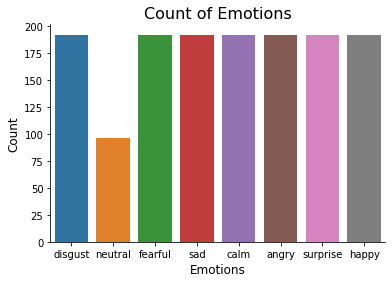

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(dataset_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

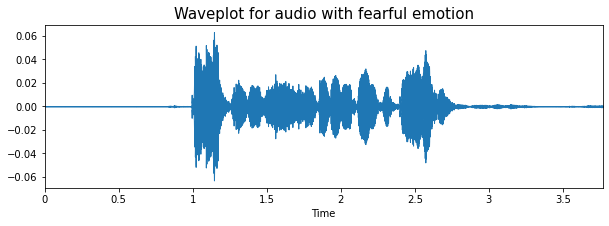

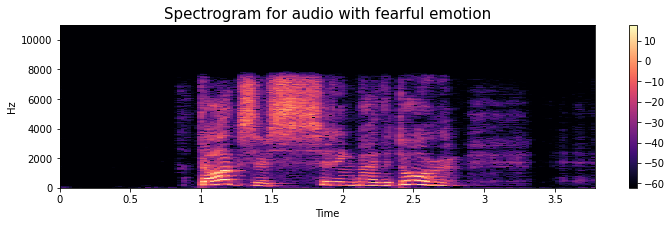

In [ ]:
emotion='fearful'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

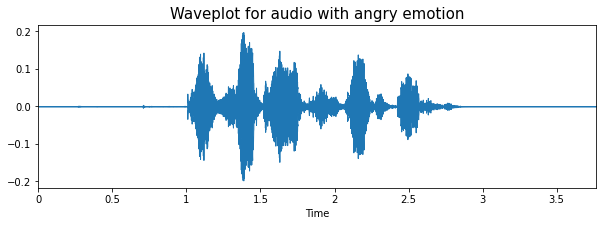

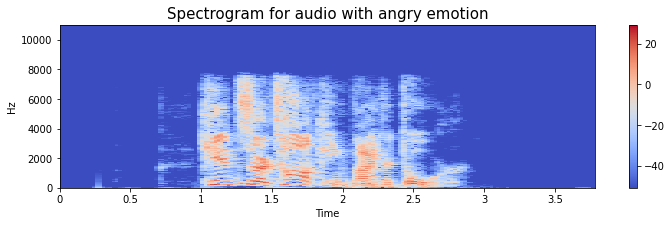

In [ ]:
emotion='angry'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

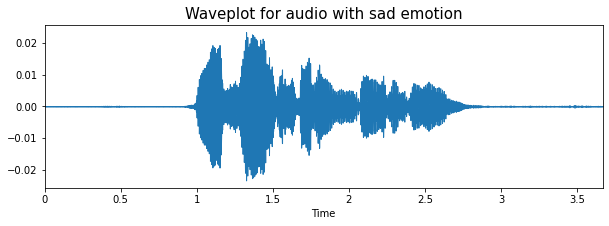

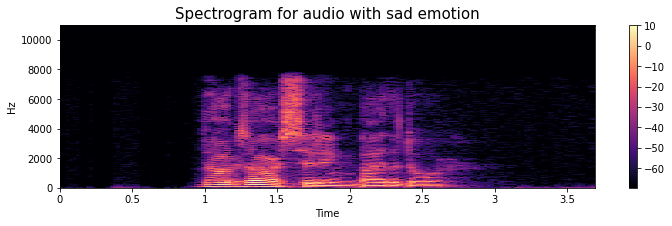

In [ ]:
emotion='sad'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

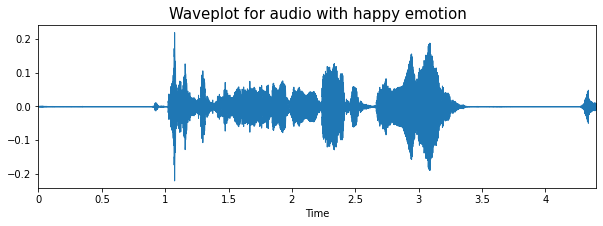

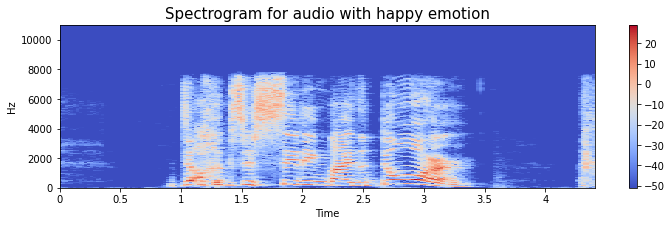

In [ ]:
emotion='happy'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


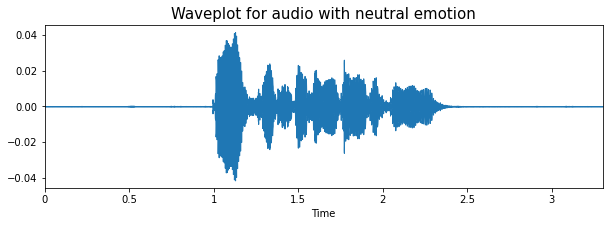

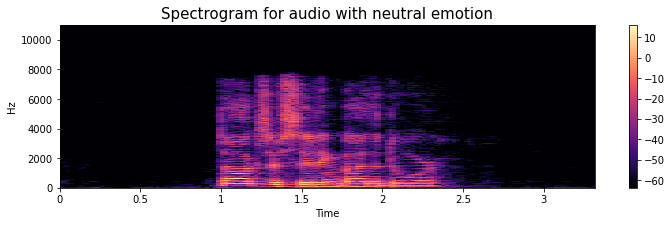

In [ ]:
emotion='neutral'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


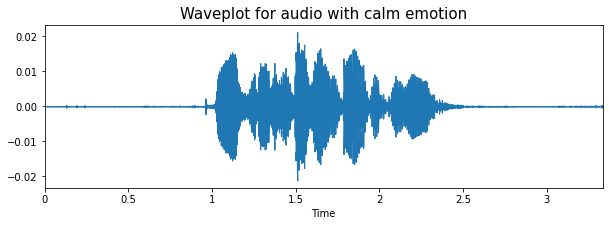

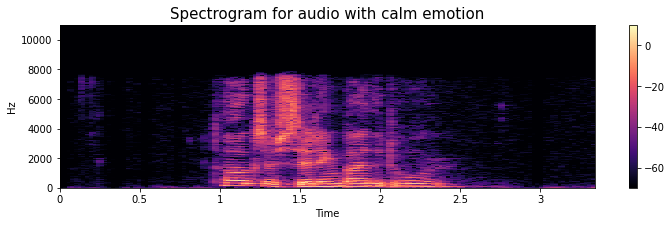

In [ ]:
emotion='calm'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


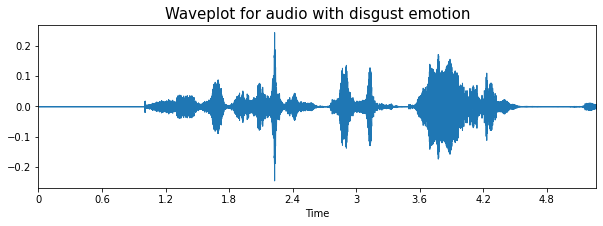

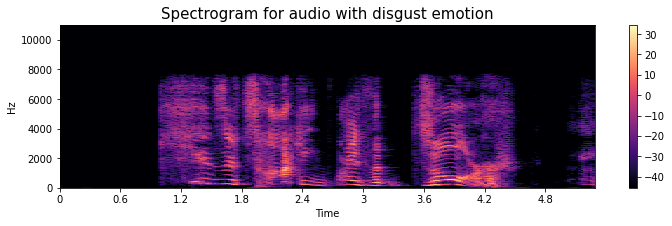

In [ ]:
emotion='disgust'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


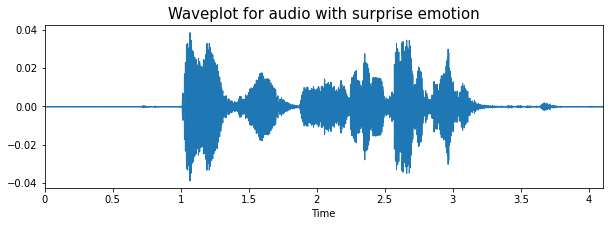

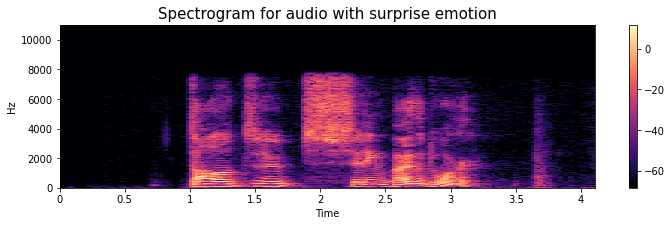

In [ ]:
emotion='surprise'
path = np.array(dataset_df.Path[dataset_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


## Data Augmentation
 

In [ ]:
# objective is to make our model invariant to those perturbations and enhace its ability to generalize.
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

path = np.array(dataset_df.Path)[1]
data, sample_rate = librosa.load(path)

Noise injection 

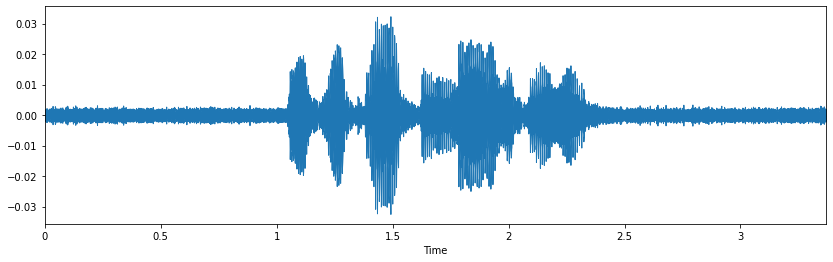

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Stretching 

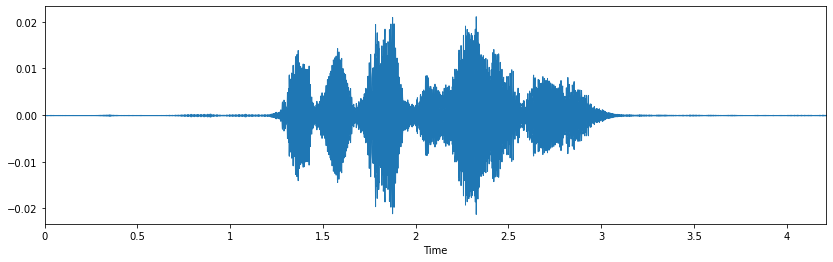

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Shifting 

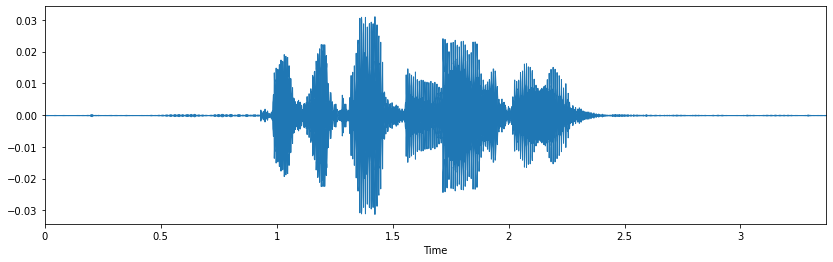

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Pitch 

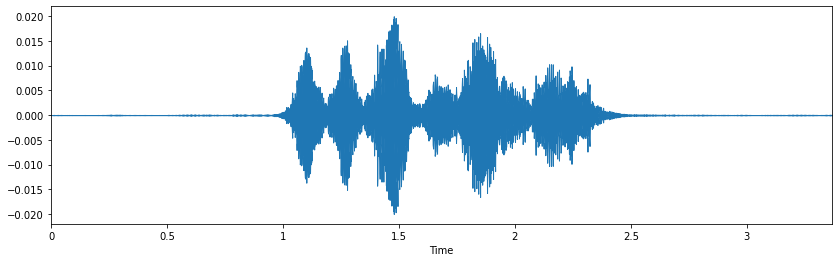

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

In [ ]:
print((X_train.shape[0], X_test.shape[0]))

(1080, 360)


In [ ]:
print(f'Features extracted: {X_train.shape[1]}')

Features extracted: 180


# Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# MLP Classifier

In [ ]:
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, 
                      hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
model.fit(X_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, predictions)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 47.50%


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
pipe_lr = Pipeline([('sc',StandardScaler()),('lr', LogisticRegression(C =4, max_iter= 10000,multi_class= 'multinomial',n_jobs =-1,random_state = 12))])
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('lr',
                 LogisticRegression(C=4, max_iter=10000,
                                    multi_class='multinomial', n_jobs=-1,
                                    random_state=12))])

In [ ]:
y_pred_lr = pipe_lr.predict(X_test)
print(accuracy_score(y_test , y_pred_lr)*100 , '%')

48.888888888888886 %


# Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
pipe_dtc = Pipeline([('sc',StandardScaler()),('dtc', DecisionTreeClassifier(criterion = 'gini',max_depth=10,min_samples_split=5, random_state = 0))])
pipe_dtc.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('dtc',
                 DecisionTreeClassifier(max_depth=10, min_samples_split=5,
                                        random_state=0))])

In [ ]:
y_pred_dtc= pipe_dtc.predict(X_test)
print(accuracy_score(y_test , y_pred_dtc)*100 , '%')

33.05555555555556 %


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
pipe_rf = Pipeline([('sc',StandardScaler()),('rf',RandomForestClassifier(bootstrap = False,
 max_depth= 10,
 max_features= 'sqrt',
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 800) )])

pipe_rf.fit(X_train, y_train)

y_pred_rf = pipe_rf.predict(X_test)

print(accuracy_score(y_test , y_pred_rf)*100 , '%')

55.00000000000001 %


# Kernel SVM

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
pipe_svc = Pipeline([('sc',StandardScaler()),('svc', SVC(kernel = 'rbf', random_state = 0))])
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()), ('svc', SVC(random_state=0))])

In [ ]:
y_pred_svc= pipe_svc.predict(X_test)
print(accuracy_score(y_test , y_pred_svc)*100 , '%')

50.27777777777778 %


In [ ]:
kernels=['linear','rbf','poly','sigmoid']
for i in kernels:
  model=SVC(kernel=i,C=1.0 ,random_state=0)
  model.fit(X_train_scaled,y_train)
  print('For kernel :' ,i)
  print('Accuracy is : ' , model.score(X_test_scaled,y_test))

For kernel : linear
Accuracy is :  0.4666666666666667
For kernel : rbf
Accuracy is :  0.5027777777777778
For kernel : poly
Accuracy is :  0.20833333333333334
For kernel : sigmoid
Accuracy is :  0.4222222222222222


In [ ]:
for i in range(1,10):
  model=SVC(kernel='poly' , degree=i , C=100)
  model.fit(X_train_scaled,y_train)
  print('Accuracy on testing data : \t' , model.score(X_test_scaled,y_test))

Accuracy on testing data : 	 0.48333333333333334
Accuracy on testing data : 	 0.5777777777777777
Accuracy on testing data : 	 0.5611111111111111
Accuracy on testing data : 	 0.41944444444444445
Accuracy on testing data : 	 0.3277777777777778
Accuracy on testing data : 	 0.28888888888888886
Accuracy on testing data : 	 0.21666666666666667
Accuracy on testing data : 	 0.19166666666666668
Accuracy on testing data : 	 0.18055555555555555


In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel = 'poly',degree=3 , C= 100)
svc.fit(X_train_scaled, y_train)

SVC(C=100, kernel='poly')

In [ ]:
y_pred_svc_scaled = svc.predict(X_test_scaled)
print(accuracy_score(y_test , y_pred_svc_scaled)*100 , '%')

56.111111111111114 %


# Xg Boost

In [ ]:
from xgboost import XGBClassifier
pipe_xgb = Pipeline([('sc',StandardScaler()),('xgb', XGBClassifier())])
pipe_xgb.fit(X_train,y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('xgb', XGBClassifier(objective='multi:softprob'))])

In [ ]:
y_pred_xgb = pipe_xgb.predict(X_test)
print(accuracy_score(y_test , y_pred_xgb)*100 , '%')

58.611111111111114 %


In [ ]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train_scaled,y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  category=UserWarning,


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [ ]:
random_search.best_estimator_

XGBClassifier(colsample_bytree=0.4, gamma=0.3, learning_rate=0.2, max_depth=10,
              objective='multi:softprob')

In [ ]:
random_search.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.3,
 'learning_rate': 0.2,
 'max_depth': 10,
 'min_child_weight': 1}

In [ ]:
classifier=xgboost.XGBClassifier(colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=5,min_child_weight=5, objective='multi:softprob')
classifier.fit(X_train_scaled,y_train)

XGBClassifier(colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=5,
              min_child_weight=5, objective='multi:softprob')

In [ ]:
y_pred_xgb_scaled = classifier.predict(X_test_scaled)
print(accuracy_score(y_test , y_pred_xgb_scaled)*100 , '%')

63.61111111111111 %


# Light Gbm

In [ ]:
import lightgbm as lgb
pipe_lgb = Pipeline([('sc',StandardScaler()),('lgb', lgb.LGBMClassifier(n_estimators=500))])
pipe_lgb.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('lgb', LGBMClassifier(n_estimators=500))])

In [ ]:
y_pred_clf = pipe_lgb.predict(X_test)
print(accuracy_score(y_test , y_pred_clf)*100 , '%')

65.27777777777779 %


# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_clf)
cm

array([[36,  0,  1,  1,  1,  1,  1,  5],
       [ 0, 39,  1,  0,  0,  5,  3,  0],
       [ 5,  3, 30,  0,  2,  1,  1,  4],
       [ 2,  1,  1, 29,  2,  2,  7,  2],
       [ 5,  2,  2,  3, 25,  2,  4,  2],
       [ 1,  7,  1,  0,  2,  9,  4,  0],
       [ 1,  4,  4,  2,  1,  2, 32,  4],
       [ 1,  0,  6,  2,  5,  1,  5, 35]])

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised'], 
                     columns = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised'] )

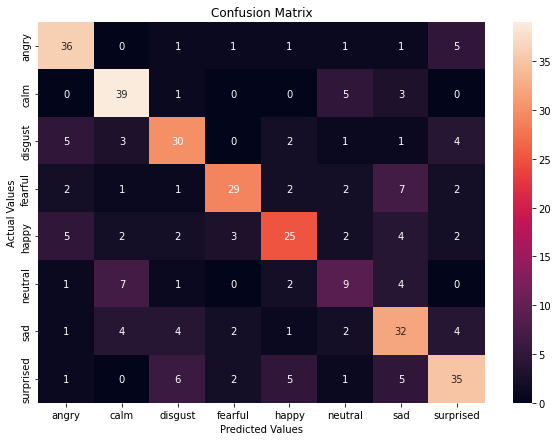

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# ROC curves

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import random

def random_hex():
  random_number = random.randint(0,16777215)
  hex_number = str(hex(random_number))
  hex_number ='#'+ hex_number[2:]
  return hex_number

def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = random_hex() , ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

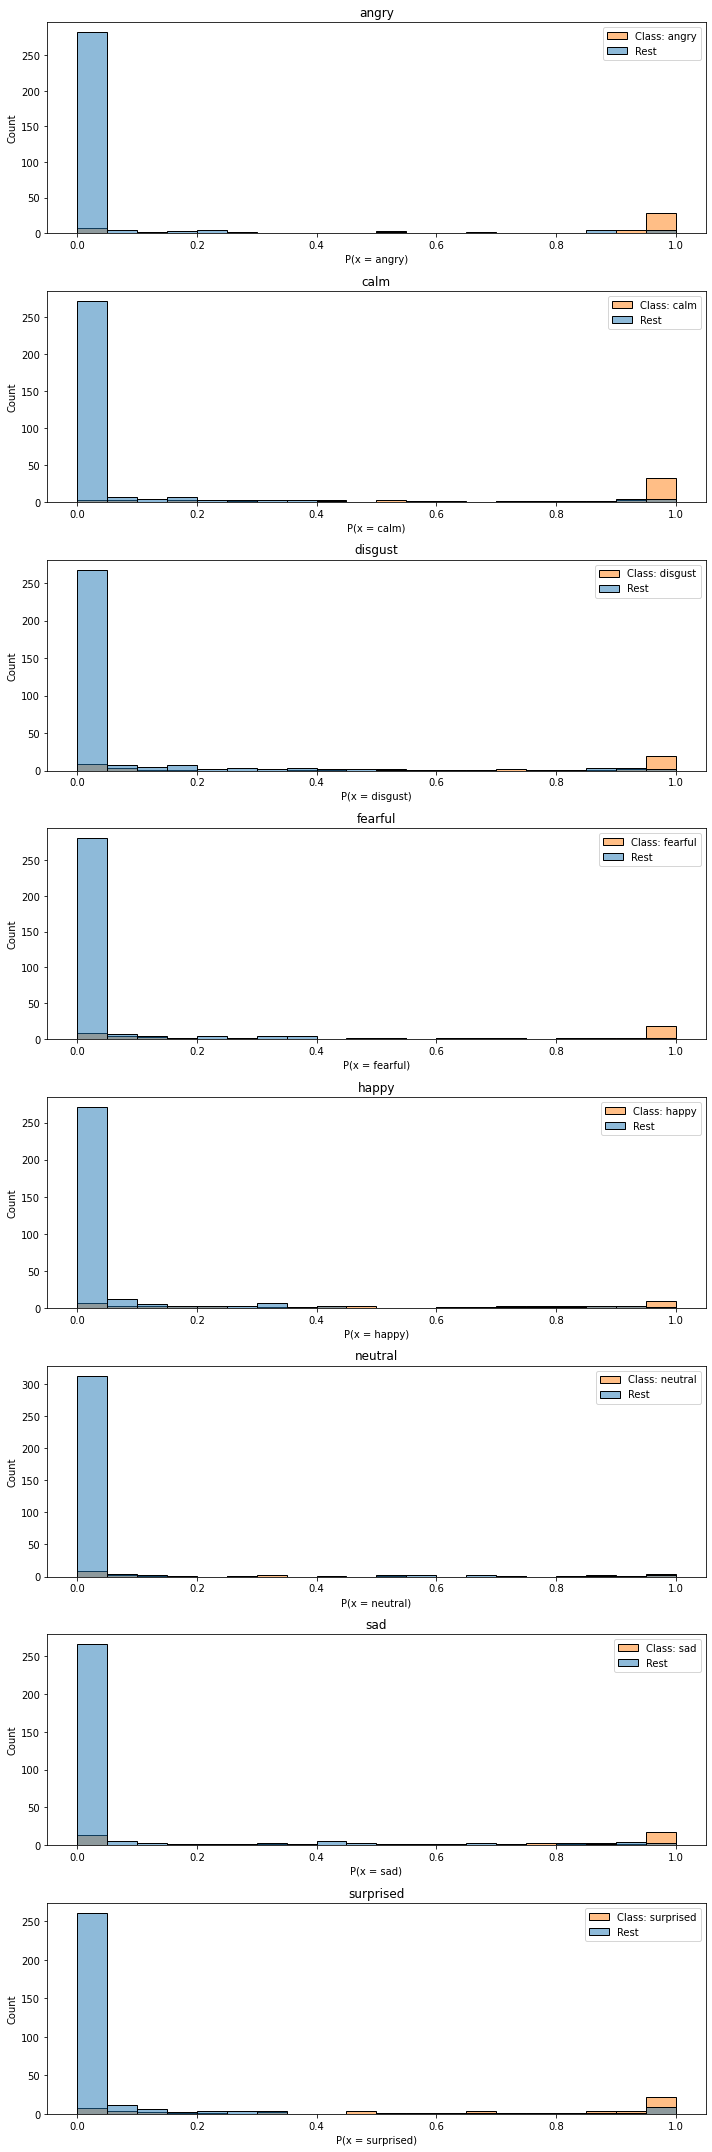

In [ ]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
y_proba = pipe_lgb.predict_proba(X_test)
X_test_df = pd.DataFrame(X_test)
plt.figure(figsize = (10, 30))
bins = [i/20 for i in range(20)] + [1]
classes = pipe_lgb.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test_df.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(8, 1, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")

plt.tight_layout()

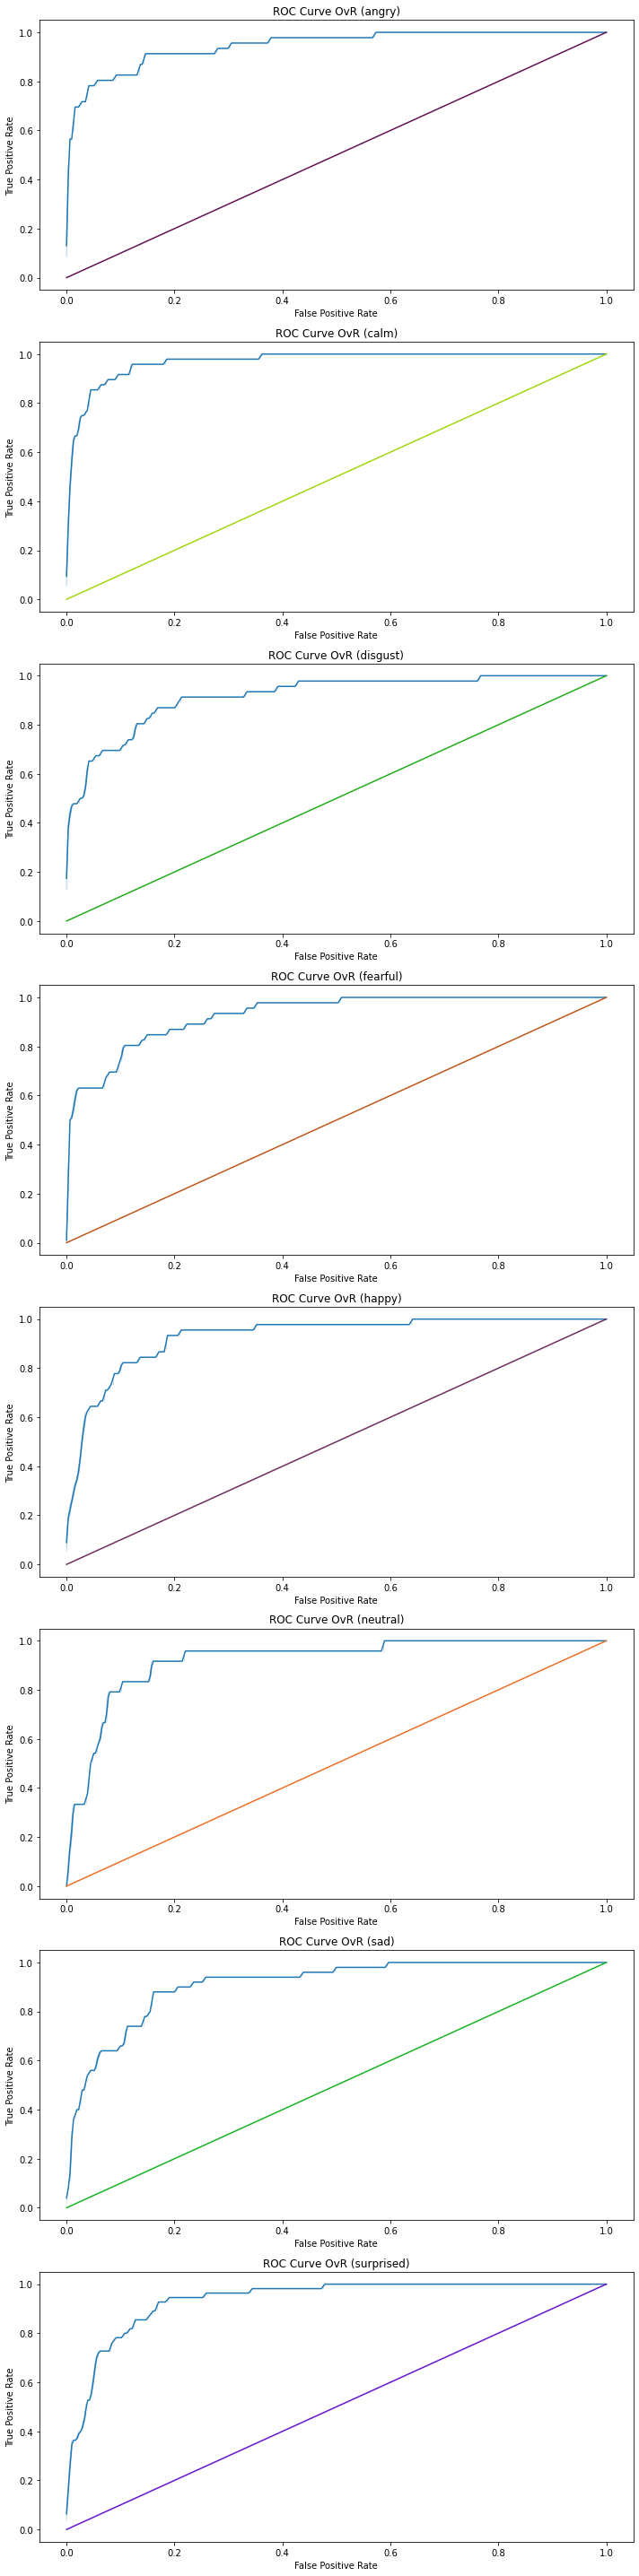

In [ ]:
plt.figure(figsize = (10, 40))
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test_df.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(8, 1, i+1)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    title = "ROC Curve OvR (" + c + ")"
    ax_bottom.set_title(title)
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

plt.tight_layout()